In [1]:
from PymoNNto import *

In [2]:
def plot_mean_vt(ni, ne1, ne2):
    plt.plot([np.mean(i) for i in ni['n.v',0]],color='orange')
    plt.plot([np.mean(i) for i in ne1['n.v',0]],color='blue')
    plt.plot([np.mean(i) for i in ne2['n.v',0]],color='green')
    plt.xlabel('iterations')
    plt.ylabel('voltage')
    plt.show()

In [3]:
def plot_It(ni, ne1, ne2):
    ni_i = [np.mean(i) for i in ni['n.I',0]]
    ne1_i = [np.mean(i) for i in ne1['n.I',0]]
    ne2_i = [np.mean(i) for i in ne2['n.I',0]]
    t = len(ni_i)
    plt.plot([ni_i[i] for i in range(t)],'orange')
    plt.plot([ne1_i[i] for i in range(t)],'blue')
    plt.plot([ne2_i[i] for i in range(t)],'green')
    plt.xlabel('iterations')
    plt.ylabel('current')
    plt.show()

In [4]:
def plot_activity(ni, ne1, ne2):
    activity = []
    for t in range(1000):
        fired_t = 0
        for n in ne1['n.fired', 0][t]:
            if n:
                fired_t += 1
        for n in ne2['n.fired', 0][t]:
            if n:
                fired_t += 1
        for n in ni['n.fired', 0][t]:
            if n:
                fired_t += 1
        activity.append(fired_t)
    plt.plot(activity,'black')
    plt.xlabel('iterations')
    plt.ylabel('activity')
    plt.show()

In [5]:
def plot_raster(ni, ne1, ne2):
    ne1_size = len(ne1['n.fired', 0][0])
    ne2_size = len(ne2['n.fired', 0][0])
    ne1_fired = []
    for t in ne1['n.fired', 0]:
        ne1_fired_t = []
        for n in range(len(t)):
            if t[n]:
                ne1_fired_t.append(n)
        ne1_fired.append(ne1_fired_t)
    ne2_fired = []
    for t in ne2['n.fired', 0]:
        ne2_fired_t = []
        for n in range(len(t)):
            if t[n]:
                ne2_fired_t.append(n + ne1_size)
        ne2_fired.append(ne2_fired_t)
    ni_fired = []
    for t in ni['n.fired', 0]:
        ni_fired_t = []
        for n in range(len(t)):
            if t[n]:
                ni_fired_t.append(n + ne1_size + ne2_size)
        ni_fired.append(ni_fired_t)  
      
    t=[0 for i in range(1000)]
    for i in range(len(ne1_fired)):
        plt.scatter([i for j in range(len(ne1_fired[i]))],ne1_fired[i],color='blue',s=1)
    for i in range(len(ne2_fired)):
        plt.scatter([i for j in range(len(ne2_fired[i]))],ne2_fired[i],color='green',s=1)
    for i in range(len(ni_fired)):
        plt.scatter([i for j in range(len(ni_fired[i]))],ni_fired[i],color='orange',s=1)
    plt.xlabel('iterations')
    plt.ylabel('neuron index')
    plt.show()

In [6]:
def plot_ut(ni, ne1, ne2, the, thi):
    plt.plot(ni['n.v', 0])
    plt.plot(ne1['n.v', 0])
    plt.plot(ne2['n.v', 0])
    plt.axhline(thi,color='black',linestyle='dashed')
    plt.axhline(the,color='black',linestyle='dashed')
    plt.xlabel('iterations')
    plt.ylabel('voltage')
    plt.show()

In [12]:
def network_setup(params):
    class LIF_main(Behaviour):

        def set_variables(self, n):
            self.set_init_attrs_as_variables(n)
            n.v = n.get_neuron_vec('uniform')*n.v_rest
            n.fired = n.get_neuron_vec() > 0
            n.dt = 0.1

        def new_iteration(self, n):

            n.v += ((n.v_rest-n.v)+n.R*n.I)*(n.dt/n.tau)

            n.fired = n.v > n.v_threshold
            if np.sum(n.fired) > 0:
                n.v[n.fired] = n.v_reset            

    class LIF_input(Behaviour):

        def set_variables(self, n):
            for synapse in n.afferent_synapses['N_e1 to N_e1']:
                synapse.W = synapse.get_synapse_mat('random',density=params['density'][0])
            for synapse in n.afferent_synapses['N_e1 to N_i']:
                synapse.W = synapse.get_synapse_mat('random',density=params['density'][1])
            for synapse in n.afferent_synapses['N_e2 to N_e2']:
                synapse.W = synapse.get_synapse_mat('random',density=params['density'][2])
            for synapse in n.afferent_synapses['N_e2 to N_i']:
                synapse.W = synapse.get_synapse_mat('random',density=params['density'][3])
            for synapse in n.afferent_synapses['N_i to N_e1']:
                synapse.W = synapse.get_synapse_mat('random',density=params['density'][4])
            for synapse in n.afferent_synapses['N_i to N_e2']:
                synapse.W = synapse.get_synapse_mat('random',density=params['density'][5])
            for synapse in n.afferent_synapses['N_i to N_i']:
                synapse.W = synapse.get_synapse_mat('random',density=params['density'][6])

            n.I = n.get_neuron_vec()

        def new_iteration(self, n):
            n.I = n.current + n.get_neuron_vec('uniform')

            for s in n.afferent_synapses['N_e1 to N_e1']:
                n.I += np.sum(s.W[:, s.src.fired], axis=1)
            for s in n.afferent_synapses['N_e1 to N_i']:
                n.I += np.sum(s.W[:, s.src.fired], axis=1)

            for s in n.afferent_synapses['N_e2 to N_e2']:
                n.I += np.sum(s.W[:, s.src.fired], axis=1)
            for s in n.afferent_synapses['N_e2 to N_i']:
                n.I += np.sum(s.W[:, s.src.fired], axis=1)

            for s in n.afferent_synapses['N_i to N_e1']:
                n.I -= np.sum(s.W[:, s.src.fired], axis=1)
            for s in n.afferent_synapses['N_i to N_e2']:
                n.I -= np.sum(s.W[:, s.src.fired], axis=1)
            for s in n.afferent_synapses['N_i to N_i']:
                n.I -= np.sum(s.W[:, s.src.fired], axis=1)  

    My_Network = Network()

    N_e1 = NeuronGroup(net=My_Network, tag='excitatory_neurons', size=params['N_e1_size'], behaviour={
        1: LIF_main(R=params['N_e_R'], v_rest=params['N_e_rest'], v_reset=params['N_e_reset'],
                    v_threshold=params['N_e_threshold'], tau=params['N_e_tau'], current=params['N_e1_current']),
        2: LIF_input(),
        9: Recorder(tag='rec1', variables=['n.v', 'n.fired', 'n.I'])
    })
    
    N_e2 = NeuronGroup(net=My_Network, tag='excitatory_neurons', size=params['N_e2_size'], behaviour={
        1: LIF_main(R=params['N_e_R'], v_rest=params['N_e_rest'], v_reset=params['N_e_reset'],
                    v_threshold=params['N_e_threshold'], tau=params['N_e_tau'], current=params['N_e2_current']),
        2: LIF_input(),
        9: Recorder(tag='rec2', variables=['n.v', 'n.fired', 'n.I'])
    })

    N_i = NeuronGroup(net=My_Network, tag='inhibitory_neurons', size=params['N_i_size'], behaviour={
        1: LIF_main(R=params['N_i_R'], v_rest=params['N_i_rest'], v_reset=params['N_i_reset'],
                    v_threshold=params['N_i_threshold'], tau=params['N_i_tau'], current=0),
        2: LIF_input(),
        9: Recorder(tag='rec3', variables=['n.v', 'n.fired', 'n.I'])
    })

    SynapseGroup(net=My_Network, src=N_e1, dst=N_e1, tag='N_e1 to N_e1')
    SynapseGroup(net=My_Network, src=N_e2, dst=N_e2, tag='N_e2 to N_e2')
    SynapseGroup(net=My_Network, src=N_i, dst=N_i, tag='N_i to N_i')
    SynapseGroup(net=My_Network, src=N_e1, dst=N_i, tag='N_e1 to N_i')
    SynapseGroup(net=My_Network, src=N_e2, dst=N_i, tag='N_e2 to N_i')
    SynapseGroup(net=My_Network, src=N_i, dst=N_e1, tag='N_i to N_e1')
    SynapseGroup(net=My_Network, src=N_i, dst=N_e2, tag='N_i to N_e2')
    
    return My_Network, N_e1, N_e2, N_i

In [8]:
def present_network_behaviour(param_set):
    
    Network, N_e1, N_e2, N_i = network_setup(param_set)

    Network.initialize()
    Network.simulate_iterations(param_set['Iterations'], measure_block_time=True)

    #plot_ut(N_i, N_e1, N_e2, param_set['N_e_threshold'],param_set['N_i_threshold'])
    plot_mean_vt(N_i, N_e1, N_e2)
    plot_raster(N_i, N_e1, N_e2)
    plot_activity(N_i, N_e1, N_e2)
    plot_It(N_i, N_e1, N_e2)

بدون در نظر گرفتن هیچ جریان ورودی به جمعیت‌ها در حالت عادی فعالیت اسپایکی از خود نشان نمی‌دهند. میانگین ولتاژ هر جمعیت مقدار ثابت دارد. دو جمعیت 400 نورونی تحریکی هست که پارامترهای نورون های آن دقیقا مشابه هستند. یک جمعیت 200 تایی نورون مهاری داریم. آستانه‌ی نورون‌های تحریکی و تاو آنها مقدار بیشتر دارد یعنی در برابر جریان‌های کوچکتری به فعالیت وا داشته می‌شوند نشبت به جمعیت مهاری. این مدل را در آزمایش اول قرار است به جریان هایی متصل کنم. پارامتر‌ها را رفته رفته نسبت به همین خالت تغیر خواهم داد تا رفتارها را ببینم. ارتباطات بین تمام جمعیت های تحریکی با مهاری و تخریکی درون خودش و مهاری با مهاری به صورت رندوم بین نیمی از نورون های جمعیت تعریف شده.

init R
init v_rest
init v_reset
init v_threshold
init tau
init current
init R
init v_rest
init v_reset
init v_threshold
init tau
init current
init R
init v_rest
init v_reset
init v_threshold
init tau
init current
1000xBatch: 1/1 (100%) 206.280ms


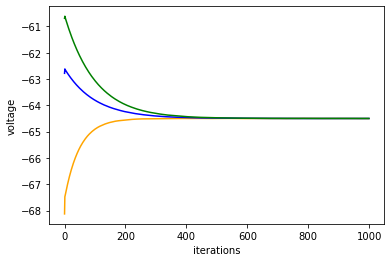

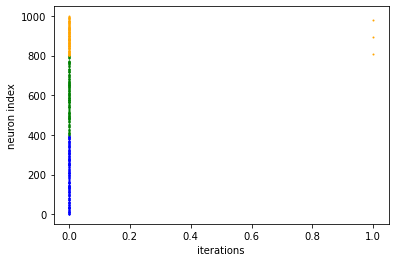

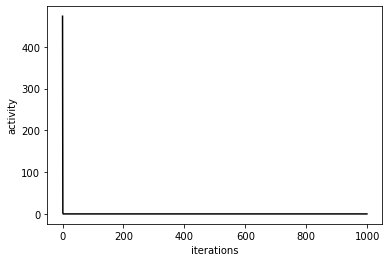

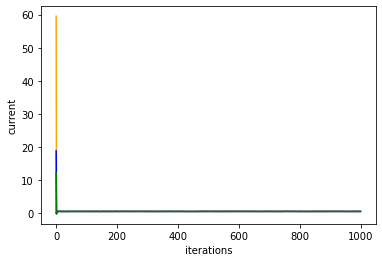

In [15]:
param_set0 ={
    'density_' :['e1_to_e1', 'e1_to_i', 'e2_to_e2' ,'e2_to_i', 'i_to_e1', 'i_to_e1' ,'i_to_i'],
    'density' : [0.5,         0.5,       0.5 ,       0.5,       0.5,       0.5 ,      0.5],
    'Iterations' : 1000,
    'N_e1_size' : 400,
    'N_e2_size' : 400,
    'N_i_size' : 200,
    'N_e_threshold' : -30,
    'N_i_threshold' : -40,
    'N_e_R' : 1,
    'N_i_R' : 1,
    'N_e_rest' : -65,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 10,
    'N_i_tau' : 5,
    'N_e1_current': 0,
    'N_e2_current': 0
}
present_network_behaviour(param_set0)

# Experiment 1

به جمعیت تحریکی اول جریان 40 و به دومی 90 متصل می‌کنم. به جمعیت مهاری جریانی متصل نیست. نویز جریان ها در نقاط پرش دار نمودار جریان-زمان مشخص است ولی نقاطی که پرش های شدید دیده می‌شود مزبوط یه جریانی است که از طریق افزایش اختلاف پتانسیل ناشی از فعال شدن و اسپایک زدن نورون‌ها در جمخیت انتشار می‌یابد و سریع فروکش می‌کند. این خالت در جمعیت مهاری هم به وایطه ی ارتباط سیناپسی که با نورون‌های تحریکی دو بخش دیگر دارد اتفاق می‌افتد.
برای راحتی کار نمودارهای جمعیت تحریکی اول را به رنگ آبی و دومی را با سبز نمایش می‌دهم. با این جریان ها هر دو جمعیت به آستانه می‌رسند و فعال می‌شوند و نورون های فعال شده بعد از مدت زمانی که زول می‌کشد دوباره به خالت استراخت برسند دوباره فعال می‌شوند.این فعالت ها را به صورت متناوب روی نمودار رستر می‌توان دید. البته فعالیتی در نورون‌های مهاری دیده نمی‌شود. به واسطه ی ارتباط های سیناپسی با نورون های جمعیت سبز و آبی اختلاف پتانیل نورون‌های مهاری بالا می‌رود و این را روی نمودار میانگین ولتاژ می‌شود دید. ولی افزایش در خدی نیست که نورون‌ها به آستانه برسند.دو جمعیت نورونی تحریکی مشابه بودند ولی آن که جریان قوی تری بهش وصل شده در بازه های زمانی مشخص فعالیت بیشتری از نورون‌هایش نشان می‌دهد. که با توجه به آنچه از قبل درباره ی عملکرد نورون‌ها می‌دانیم قابل انتظار است.

init R
init v_rest
init v_reset
init v_threshold
init tau
init current
init R
init v_rest
init v_reset
init v_threshold
init tau
init current
init R
init v_rest
init v_reset
init v_threshold
init tau
init current
1000xBatch: 1/1 (100%) 285.628ms


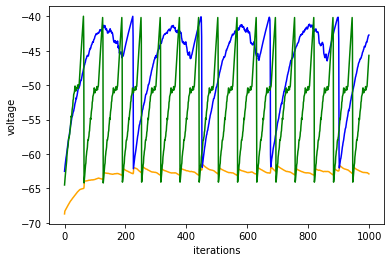

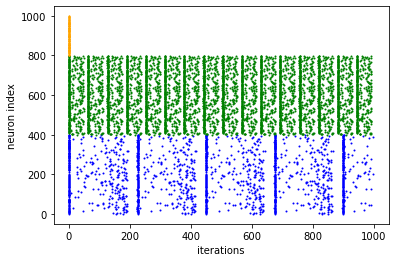

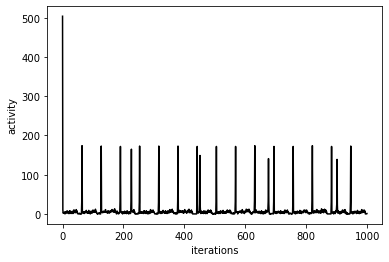

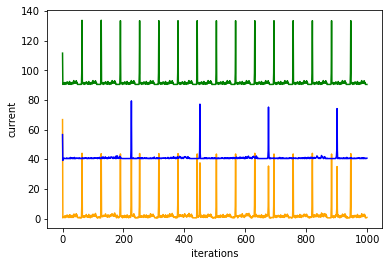

In [17]:
param_set1 ={
    'density_' :['e1_to_e1', 'e1_to_i', 'e2_to_e2' ,'e2_to_i', 'i_to_e1', 'i_to_e2' ,'i_to_i'],
    'density' : [0.5,         0.5,       0.5 ,       0.5,       0.5,       0.5 ,      0.5],
    'Iterations' : 1000,
    'N_e1_size' : 400,
    'N_e2_size' : 400,
    'N_i_size' : 200,
    'N_e_threshold' : -30,
    'N_i_threshold' : -40,
    'N_e_R' : 1,
    'N_i_R' : 1,
    'N_e_rest' : -65,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 10,
    'N_i_tau' : 5,
    'N_e1_current': 40,
    'N_e2_current': 90
}
present_network_behaviour(param_set1)

# Experiment 2

با هدف اینکه در همین جریان هایی که وارد کردیم بتوانم فعالیت نورون‌های مهاری را تحریک کنم و تاقیرشان بر جمعیت‌ها را ببینم ارتباط ‌ها را تغیر می دهم. هدف بررسی این است که ببینم آیا با افزایش ارتباط‌ها از جمعیت های تحریکی به مهاری می‌توان اختلاف پتانسیل آن را نسبت به حالت قبل بیشتر کرد؟
نتیجه با خالت قبلی تفاوتی نکرد.
برای اینکه فعالیت جمعیت مهاری را ببینم مقاومت نورون‌های این جمعیت را بیشتر می‌کنم
از زمان فعال شدن جمعیت مهاری تا زمان 500 اوج فعالیت‌ها را داریم و بعد از آن به طور کلی کمی فعالت هر 3 حمعیت افت می‌کند. جریان ها هم کمتر شدند ولی فعالیت مهاری‌ها کاهش پیدا نمی‌کند و متناوب ادامه دار است. بقیه تناوب فعالیت‌هایشان از تناوبقبلی که داشتند تغیری نمی‌کند. 

init R
init v_rest
init v_reset
init v_threshold
init tau
init current
init R
init v_rest
init v_reset
init v_threshold
init tau
init current
init R
init v_rest
init v_reset
init v_threshold
init tau
init current
1000xBatch: 1/1 (100%) 237.338ms


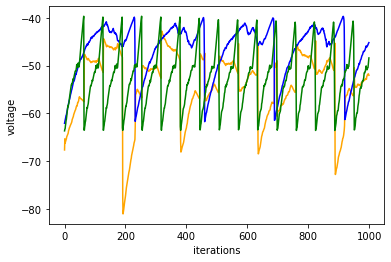

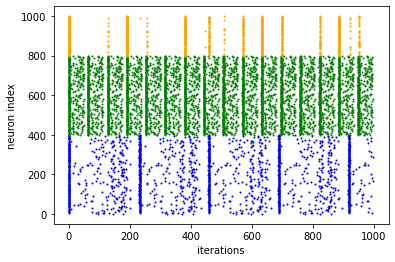

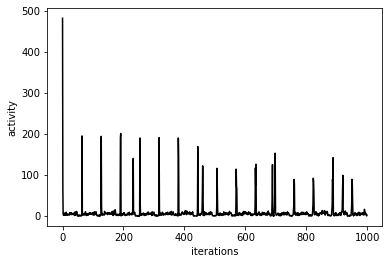

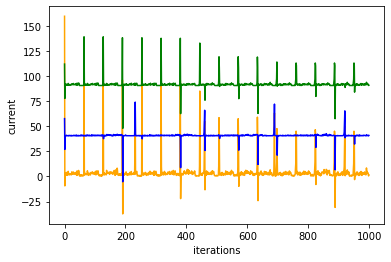

In [20]:
param_set2 ={
    'density_' :['e1_to_e1', 'e1_to_i', 'e2_to_e2' ,'e2_to_i', 'i_to_e1', 'i_to_e2' ,'i_to_i'],
    'density' : [0.5,         1.0,       0.5 ,       1.0,       0.5,       0.5 ,      0.5],
    'Iterations' : 1000,
    'N_e1_size' : 400,
    'N_e2_size' : 400,
    'N_i_size' : 200,
    'N_e_threshold' : -30,
    'N_i_threshold' : -40,
    'N_e_R' : 1,
    'N_i_R' : 5,
    'N_e_rest' : -65,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 10,
    'N_i_tau' : 5,
    'N_e1_current': 40,
    'N_e2_current': 90
}
present_network_behaviour(param_set2)

# Experiment 3

تعداد نورون‌های جمعیتی که جریان قوی تر را می‌گیرد را اضافه می‌کنم با هدف این که آیا می تواند تاثیر بیشتری روی جمعیت مهاری بگذارد و جمعیت آبی را مهار کند یا نه. تراکم ارتباط نورون‌های مهاری به جمعیت آبی را هم بیشتر می‌کنم.
در نمودارهای قبل جاهایی که جریان منفی داشتیم تاثیر مهاری جمعیت مهاری بود. در این نمودارها منفی شدن جریان آبی بسیار سدیدتر و به دفعات بیشتر رخ می‌دهد.
تاقیر مشابه روی دو جمعیت دیگر هم هست ولی روی آبی شدیدتر اعمال شده. جریان قویتر جمعیت سبز در ابتدا به اندازه ی کافی برای مهار جمعیت سبز از طریق جمعیت مهاری قوی نبود. همان جریان با تغیر اندازه و تراکم ارتباط در آزمایش 3 تاثیر واضح ت دارد.

init R
init v_rest
init v_reset
init v_threshold
init tau
init current
init R
init v_rest
init v_reset
init v_threshold
init tau
init current
init R
init v_rest
init v_reset
init v_threshold
init tau
init current
1000xBatch: 1/1 (100%) 286.178ms


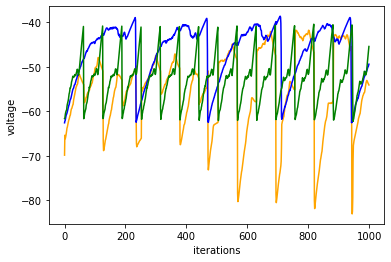

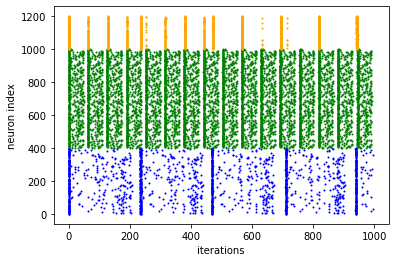

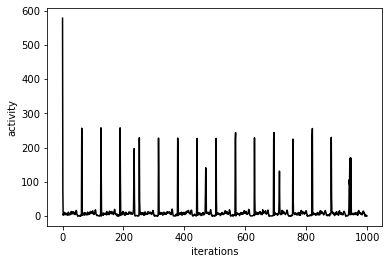

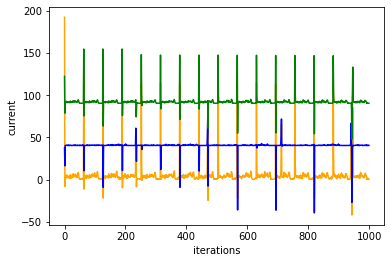

In [22]:
param_set3 ={
    'density_' :['e1_to_e1', 'e1_to_i', 'e2_to_e2' ,'e2_to_i', 'i_to_e1', 'i_to_e2' ,'i_to_i'],
    'density' : [0.5,         1.0,       0.5 ,       1.0,       0.8,       0.5 ,      0.5],
    'Iterations' : 1000,
    'N_e1_size' : 400,
    'N_e2_size' : 600,
    'N_i_size' : 200,
    'N_e_threshold' : -30,
    'N_i_threshold' : -40,
    'N_e_R' : 1,
    'N_i_R' : 5,
    'N_e_rest' : -65,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 10,
    'N_i_tau' : 5,
    'N_e1_current': 40,
    'N_e2_current': 90
}
present_network_behaviour(param_set3)

# Experiment 4

جریان سبز را بیشتر می‌کنم. تاو نورون‌های مهاری را هم برابر 10 افزایش می‌دهم. جریانی که در جمعیت /ابی جریان دارد به طور ثابت همان ورودی اولیه ی ما می‌شود و جاهایی افت دارد که به مفداری کمتر پرش می‌کند. این نقاط روی نمودار فعالیت نورون‌های مهاری به شدت بالاست تا جایی که بعد از این زمان شدت فعالیت نورون‌های مهاری باعت افت جریان در بعد از این نقطه ها در هر 3 جمعیت می‌شود.
علاوه بر این برهه هایی از نمودار هست که روی رسترلات واضح تر هستند و فعالیت جمعیت سبز تنک تر می‌شود. و در این ناخیه ها اگر جمعیت مهاری هم در حال عبور جریان کمی باشد، فعالیت جمعیت آبی به صورت یک پرش کوتاه مثبت روی جریان دیده می‌شود. این‌ها همان نقاط متراکم فعالیت آبی نمودار رسترپلات هستند و روی نمودار میانگین ولتاژ هم به صورت پرش هایی نمایش داده شده که به شیب ملایمی افت می‌کنند.

init R
init v_rest
init v_reset
init v_threshold
init tau
init current
init R
init v_rest
init v_reset
init v_threshold
init tau
init current
init R
init v_rest
init v_reset
init v_threshold
init tau
init current
1000xBatch: 1/1 (100%) 371.935ms


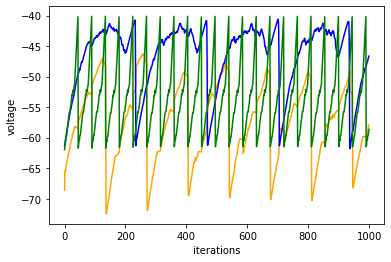

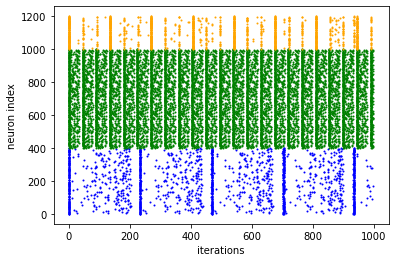

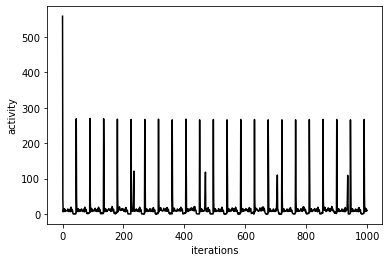

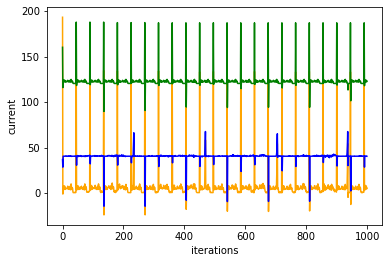

In [25]:
param_set4 ={
    'density_' :['e1_to_e1', 'e1_to_i', 'e2_to_e2' ,'e2_to_i', 'i_to_e1', 'i_to_e2' ,'i_to_i'],
    'density' : [0.5,         1.0,       0.5 ,       1.0,       0.8,       0.5 ,      0.5],
    'Iterations' : 1000,
    'N_e1_size' : 400,
    'N_e2_size' : 600,
    'N_i_size' : 200,
    'N_e_threshold' : -30,
    'N_i_threshold' : -40,
    'N_e_R' : 1,
    'N_i_R' : 5,
    'N_e_rest' : -65,
    'N_i_rest' : -65,
    'N_e_reset' : -80,
    'N_i_reset' : -80,
    'N_e_tau' : 10,
    'N_i_tau' : 10,
    'N_e1_current': 40,
    'N_e2_current': 120
}
present_network_behaviour(param_set4)